In [1]:
%pip freeze

abtem @ file:///home/jilek/abtem/abTEM
anyio==4.3.0
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
ase==3.22.1
asttokens==2.4.1
async-lru==2.0.4
attrs==23.2.0
Babel==2.14.0
beautifulsoup4==4.12.3
bleach==6.1.0
certifi==2024.2.2
cffi==1.16.0
charset-normalizer==3.3.2
click==8.1.7
cloudpickle==3.0.0
colorspacious==1.1.2
comm==0.2.2
contourpy==1.2.1
cupy==13.2.0
cycler==0.12.1
dask==2024.4.2
debugpy==1.8.1
decorator==5.1.1
defusedxml==0.7.1
dill==0.3.8
distributed==2024.4.2
emdfile==0.0.14
exceptiongroup==1.2.1
executing==2.0.1
fastjsonschema==2.19.1
fastrlock==0.8.2
filelock==3.13.4
flexcache==0.3
flexparser==0.3.1
fonttools==4.51.0
fqdn==1.5.1
fsspec==2024.3.1
gdown==5.1.0
h11==0.14.0
h5py==3.11.0
hdf5plugin==4.4.0
httpcore==1.0.5
httpx==0.27.0
hyperspy==2.1.1
hyperspy-swift-library @ file:///home/jilek/projects/vienna/hyperspy_swift_library
idna==3.7
imageio==2.34.1
importlib_metadata==7.1.0
ipykernel==6.29.4
ipympl==0.9.4
ipython==8.23.0
ipython-genutils=

In [2]:
#conda environment: pokus_py4DSTEM 
#abtem version: 4d630003af7a2d33ee63e9a02f1846549d04be00

import os
os.environ["MKL_NUM_THREADS"] = "16"
os.environ["NUMEXPR_NUM_THREADS"] = "16"
os.environ["OMP_NUM_THREADS"] = "16"

import numpy as np
import matplotlib.pyplot as plt
from abtem import *

from abtem.noise import poisson_noise
import scipy.constants as c
from abtem.scan import PositionScan
from abtem.reconstruct import invms
from abtem.measure import bandlimit

from abtem.custom import get_gaussian_spread
from abtem.custom import get_radiation_dose
from abtem.custom import incoherent_scan
from abtem.custom import incoherent_scan_mc
from abtem.custom import sample_probe
from abtem.custom import incoherent_scan_mc_fp
from abtem.custom import incoherent_probe, get_probe_radius
from abtem.custom import crop
from abtem.custom import semiangle_2_sampling_extent,semiangle_gpts_2_extent
from abtem.custom import decimate_measurement
from abtem.utils import fft_crop,fft_shift
import cupy as cp
import h5py
import pathlib

import matplotlib

from sample import gen_rnd_tubes

import sys 
sys.path.append("../07_deep_stem/02_simulated_testing_data_LINK") #07_deep_stem: d27c25c5c9ef530e93488680ca3c1a0b797a2e80
from utils import get_positions, get_downsampled_phase, get_downsampled_mask
from materials.utils import get_potential_from_atoms



In [3]:
energy_orig = 22e3
energy = 281e3 #8x: 800e3 #4x: 281e3 #1x: 22e3
fac_lambda=Probe(energy=energy_orig).wavelength/Probe(energy=energy).wavelength
fac_lambda #prislusne pronasobit reciprocal_oversampling.. 

3.992674124096253

In [4]:
from abtem.transfer import scherzer_defocus

In [5]:
scherzer_defocus(Cs=5e-3/1e-10,energy=energy)

1239.6562972657016

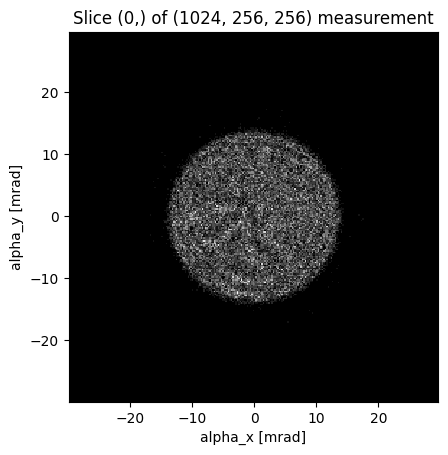

In [6]:
#matplotlib.interactive(True)

#mempool = cp.get_default_memory_pool()


#def run(input_i, output_path,single_patch=False, input_path="data/orig/", input_suffix=".jpg" ,device="gpu"):
if True:
    device = "gpu"
    # Domain
    #energy = 22e3
    px_size = 56e-6
    px_num = 256
    camera_length = 240e-3
    angular_sampling = px_size/camera_length*1e3 # in mrad
    angular_extent = angular_sampling * px_num/2  # only semi angle

    binning = 1
    reciprocal_oversampling = 2*4
    direct_oversampling = 1
    sampling, extent = semiangle_2_sampling_extent(angular_extent,px_num/binning,energy=energy,direct_oversampling=direct_oversampling,reciprocal_oversampling=reciprocal_oversampling)

    # Potential, aberrations, probe

    atoms = gen_rnd_tubes(1)#reciprocal_oversampling)
    atoms.set_chemical_symbols(["Ti" for i in range(len(atoms))])
    _,potential=get_potential_from_atoms(atoms,extent=extent,sampling=sampling)
    potential_p=potential.build()
    if potential_p is None:
        assert(True)
        #return(False)    

    #energy_spread = 0.6
    #Cc = 1.34e-3/1e-10
    #focal_spread = energy_spread/energy * Cc # 1/e width of focal distribution
    temporal_sigma = 0#focal_spread/np.sqrt(2) # std of focal distribution (normal distribution is proportional to e**( 1/2*(x/std)**2) )
    #B_r=1e8

    semiangle_cutoff = 15.0
    alpha=semiangle_cutoff*1e-3

    #aberrations = get_aberrations(scale_all=1,aberrations_set={'C10':350})
    aberrations = {'C10':-7077,'C30':5e-3/1e-10,'C12':1e-5*2000,'C23':100000}
    probe = Probe(energy=energy, semiangle_cutoff=semiangle_cutoff,rolloff=2, **aberrations, device=device,sampling=sampling,extent=extent)

    ##potential_p.project().show()
    ##probe.build().show()
    ##plt.plot(np.abs(probe.build().array[probe.gpts[0]//2,:]).get()**2)

    # Detector, scanning parameters

    detector_p = PixelatedDetector(None)

    #I=50e-12
    spatial_sigma = 0#get_gaussian_spread(probe.ctf.semiangle_cutoff,probe.energy,B_r,I)

    incoh_probe=incoherent_probe(probe,temporal_sigma=temporal_sigma,spatial_sigma=spatial_sigma)
    r, _, _, _= get_probe_radius(probe_measurement=incoh_probe,current_ratio=0.90)
    d=2*r
    scan_gpts = 32
    scan_sampling = 100/32#d*0.15/8#*np.random.uniform(0.15,0.5)
    positions=get_positions(scan_gpts,np.array(probe.extent),scan_sampling)
    scan_p=PositionScan(positions=positions)

    #|######### Estimating noise

    probe_dummy=probe.copy()
    probe_dummy.sampling=np.array(probe.sampling)*direct_oversampling/2 # 
    incoh_probe_dummy=incoherent_probe(probe_dummy,temporal_sigma=temporal_sigma,spatial_sigma=spatial_sigma)
    if device=="gpu":
        xp=cp
    else:
        xp=np
    max_dose_1,_=get_radiation_dose(incoh_probe_dummy,xp.array(positions),1,fft=False)


    #el=I*100e-6/c.e# number of electrons in diffraction pattern
    targeted_dose = 5000 # el/angstrom
    el = targeted_dose/max_dose_1
    ##print(el)

    phase_downsampled = get_downsampled_phase(potential_p,direct_oversampling,energy=probe.energy)
    if phase_downsampled is None:
        print("No downsampled phase")
        assert(True)
        #return(None)

    #mask = get_downsampled_mask(probe, direct_oversampling, thr_fac = 0.1, positions = positions, temporal_sigma = 0, spatial_sigma = 0)
    #mask_finer = get_downsampled_mask(probe, direct_oversampling//2, thr_fac = 0.1, positions = positions, temporal_sigma = 0, spatial_sigma = 0)
    
    #|######### Measurement

    #measurement=incoherent_scan_mc(probe,positions,detector_p,potential_p,temporal_sigma=temporal_sigma,spatial_sigma=spatial_sigma,max_batch_scan=100) 
    measurement=probe.scan(scan_p,detectors=detector_p,potential=potential_p,max_batch=50,pbar=False)

    measurement_crop=crop(measurement,extent=(angular_extent*2+1e-6,angular_extent*2+1e-6))

    # Downsampling diffraction pattern

    measurement_resampled = decimate_measurement(measurement_crop,reciprocal_oversampling)

    #| Apply noise or dont?

    norm=np.mean(np.sum(measurement.array,(-2,-1))) # average of fraction !uncropped! measurements(should be close to one, but it is a bit less then one cuz some electrons go past antialiasing aperture)
    if 1:
        measurement_noisy = poisson_noise(measurement_resampled/norm, dose=el,pixel_area=1)/el # el can be set based on current and dwell time or better it can be parametrized with targeted dose (el/angstron^2), then el=targeted_dose/max_dose_1, max_dose_1 depends on shape of a probe and step size.
    else:
        measurement_noisy = measurement_resampled

    measurement_noisy.show()
    plt.show()

#run()
#    return(True)

##run(jpg_i, output_path)
##from multiprocessing.pool import ThreadPool <- dont use!
#from multiprocessing.pool import Pool
#from functools import partial
#
#MAX_THREADS = 9
#
#import time 
#s=time.time()
#if __name__ == "__main__":
#    with Pool(MAX_THREADS) as p:
#        #tot=p.map(partial(run,output_path="data/export/"), range(0,100))
#        p.map(partial(run,output_path="data/export/"), range(0,10000))
#e=time.time()
#print((e-s),"s")


In [7]:
probe.sampling

(0.34302404806931014, 0.34302404806931014)

In [8]:
probe.show(power=0.4)

(<Axes: xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7f3d2ed8a470>)

In [9]:
plt.figure()
probe.ctf.show()

<Axes: xlabel='alpha [mrad]', ylabel='Envelope'>

In [10]:
probe.build().diffraction_pattern().show()

(<Axes: xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x7f3d105f8280>)

(<Axes: title={'center': 'Slice (0,) of (1024, 2048, 2048) measurement'}, xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x7f3d1044a710>)

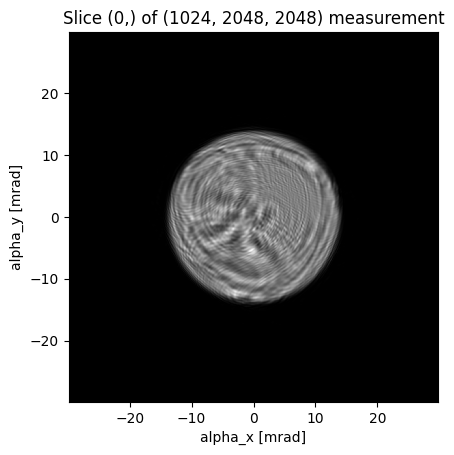

In [11]:
measurement.show()

In [12]:
probe.show(power=0.5)

(<Axes: xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7f3d104b28f0>)

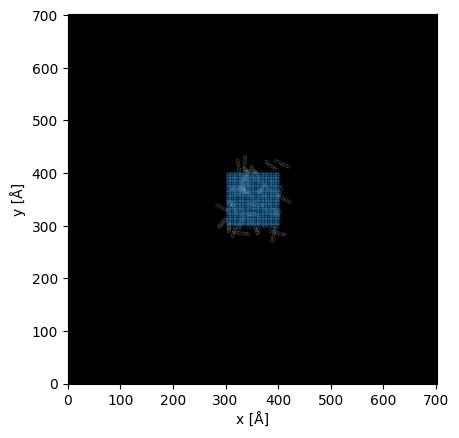

In [13]:
potential.build().project().show()
plt.plot(positions[:,0],positions[:,1],"x",markersize=1,alpha=0.5)

In [14]:
#%matplotlibz inline
from tfs_utils.aberrations_fit_utils import *

In [15]:
aberrations_real_coefs=get_real_coefs()                                                                                                                                                    
aberrations_complex_coefs=get_complex_coefs(aberrations_real_coefs)                                                                                                                        
series, alpha_x, alpha_y = get_series(aberrations_complex_coefs=aberrations_complex_coefs)                                                                                                 
                                                                                                                                                                                           
lmbda=sp.Symbol("lambda",real=True)                                                                                                                                                        
wave_deviation=2*sp.pi/lmbda*sp.re(sp.nsimplify(series,1e-9))                                                                                                                              
                                                                                                                                                                                           
wave_deviation                                                                                                                                                                             
                                                                                                                                                                                           
#wave_deviation.expand().coeff(aberrations_real_coefs[1,2,0]) # as_coefficient() je pouze na podeleni expression mym koeficientem, coeff je potreba..                                      
                                                                                                                                                                                           
k_x,k_y=sp.symbols('k_x,k_y',real=True)                                                                                                                                                    
wave_deviation_k=wave_deviation.subs(alpha_x,k_x*lmbda)                                                                                                                                    
wave_deviation_k=wave_deviation_k.subs(alpha_y,k_y*lmbda)                                                                                                                                  
wave_deviation_k                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
######                                                                                                                                                                                     
                                                                                                                                                                                           
derivation_kx=wave_deviation_k.diff(k_x)                                                                                                                                                   
derivation_ky=wave_deviation_k.diff(k_y)                                                                                                                                                   
                                                                                                                                                                                           
derivation_kx                                                                                                                                                                              
                                                                                                                                                                                           
derivation_ky                                                                                                                                                                              
                                                                                                                                                                                           
########                                                                                                                                                                                   
                                                                                                                                                                                           
derivation_kx_kx=derivation_kx.diff(k_x).doit()                                                                                                                                            
derivation_kx_ky=derivation_kx.diff(k_y).doit()                                                                                                                                            
derivation_ky_kx=derivation_ky.diff(k_x).doit()                                                                                                                                            
derivation_ky_ky=derivation_ky.diff(k_y).doit() # just do it! doit() - Evaluates unevaluated derivative (without this sp.lambdify() in get_nd_der_basis() failed!)                         

In [16]:
series

0.5*C_1,0,0*(alpha_x - I*alpha_y)**1.0*(alpha_x + I*alpha_y)**1.0 + 0.25*C_3,0,0*(alpha_x - I*alpha_y)**2.0*(alpha_x + I*alpha_y)**2.0 + (0.5*C_1,2,0 + 0.5*I*C_1,2,1)*(alpha_x + I*alpha_y)**2.0 + (0.333333333333333*C_2,1,0 + 0.333333333333333*I*C_2,1,1)*(alpha_x - I*alpha_y)**1.0*(alpha_x + I*alpha_y)**2.0 + (0.333333333333333*C_2,3,0 + 0.333333333333333*I*C_2,3,1)*(alpha_x + I*alpha_y)**3.0 + (0.25*C_3,2,0 + 0.25*I*C_3,2,1)*(alpha_x - I*alpha_y)**1.0*(alpha_x + I*alpha_y)**3.0 + (0.25*C_3,4,0 + 0.25*I*C_3,4,1)*(alpha_x + I*alpha_y)**4.0

In [17]:
wave_deviation

2*pi*(C_1,0,0*(alpha_x**2 + alpha_y**2)/2 + C_1,2,0*(alpha_x**2 - alpha_y**2)/2 - C_1,2,1*alpha_x*alpha_y + C_2,3,0*(alpha_x**3 - 3*alpha_x*alpha_y**2)/3 - C_2,3,1*(3*alpha_x**2*alpha_y - alpha_y**3)/3 + C_3,0,0*(alpha_x - I*alpha_y)**2*(alpha_x + I*alpha_y)**2/4 + C_3,4,0*(alpha_x**4 - 6*alpha_x**2*alpha_y**2 + alpha_y**4)/4 - C_3,4,1*(4*alpha_x**3*alpha_y - 4*alpha_x*alpha_y**3)/4 - 2*alpha_x*alpha_y*(-C_2,1,0*alpha_y/3 + C_2,1,1*alpha_x/3) + (alpha_x**2 - alpha_y**2)*(C_2,1,0*alpha_x/3 + C_2,1,1*alpha_y/3) + (alpha_x**3 - 3*alpha_x*alpha_y**2)*(C_3,2,0*alpha_x/4 + C_3,2,1*alpha_y/4) - (-C_3,2,0*alpha_y/4 + C_3,2,1*alpha_x/4)*(3*alpha_x**2*alpha_y - alpha_y**3))/lambda

In [18]:
wave_deviation.expand().coeff(aberrations_real_coefs[1,2,0]) # as_coefficient() je pouze na podeleni expression mym koeficientem, coeff je potreba..

pi*alpha_x**2/lambda - pi*alpha_y**2/lambda

In [19]:
aberrations_real_coefs[1,2,0]

C_1,2,0

In [20]:
derivation_kx

2*pi*(C_1,0,0*k_x*lambda**2 + C_1,2,0*k_x*lambda**2 - C_1,2,1*k_y*lambda**2 + C_2,1,0*lambda*(k_x**2*lambda**2 - k_y**2*lambda**2)/3 - 2*C_2,1,1*k_x*k_y*lambda**3/3 + C_2,3,0*(3*k_x**2*lambda**3 - 3*k_y**2*lambda**3)/3 - 2*C_2,3,1*k_x*k_y*lambda**3 + C_3,0,0*lambda*(k_x*lambda - I*k_y*lambda)**2*(k_x*lambda + I*k_y*lambda)/2 + C_3,0,0*lambda*(k_x*lambda - I*k_y*lambda)*(k_x*lambda + I*k_y*lambda)**2/2 + C_3,2,0*lambda*(k_x**3*lambda**3 - 3*k_x*k_y**2*lambda**3)/4 - C_3,2,1*lambda*(3*k_x**2*k_y*lambda**3 - k_y**3*lambda**3)/4 + C_3,4,0*(4*k_x**3*lambda**4 - 12*k_x*k_y**2*lambda**4)/4 - C_3,4,1*(12*k_x**2*k_y*lambda**4 - 4*k_y**3*lambda**4)/4 - 6*k_x*k_y*lambda**3*(-C_3,2,0*k_y*lambda/4 + C_3,2,1*k_x*lambda/4) + 2*k_x*lambda**2*(C_2,1,0*k_x*lambda/3 + C_2,1,1*k_y*lambda/3) - 2*k_y*lambda**2*(-C_2,1,0*k_y*lambda/3 + C_2,1,1*k_x*lambda/3) + (3*k_x**2*lambda**3 - 3*k_y**2*lambda**3)*(C_3,2,0*k_x*lambda/4 + C_3,2,1*k_y*lambda/4))/lambda

In [21]:
###########################

In [22]:
from collections import defaultdict

In [23]:
aberrations_real_coefs

{(1, 0, 0): C_1,0,0,
 (1, 2, 0): C_1,2,0,
 (1, 2, 1): C_1,2,1,
 (2, 1, 0): C_2,1,0,
 (2, 1, 1): C_2,1,1,
 (2, 3, 0): C_2,3,0,
 (2, 3, 1): C_2,3,1,
 (3, 0, 0): C_3,0,0,
 (3, 2, 0): C_3,2,0,
 (3, 2, 1): C_3,2,1,
 (3, 4, 0): C_3,4,0,
 (3, 4, 1): C_3,4,1}

In [24]:
aberrations_de=defaultdict(int)
for i in aberrations_real_coefs.values():
    aberrations_de[i]=0
aberrations_de[aberrations_real_coefs[(1,0,0)]]=aberrations["C10"] #!!!!!!!! TODO
aberrations_de[aberrations_real_coefs[(3,0,0)]]=aberrations["C30"] #!!!!!!!! TODO
aberrations_de[aberrations_real_coefs[(1,2,0)]]=aberrations["C12"] #!!!!!!!! TODO
aberrations_de[aberrations_real_coefs[(2,3,0)]]=aberrations["C23"] #!!!!!!!! TODO
aberrations_de=dict(aberrations_de)

In [25]:
aberrations

{'C10': -7077, 'C30': 50000000.0, 'C12': 0.02, 'C23': 100000}

In [26]:
aberrations_de

{C_1,0,0: -7077,
 C_1,2,0: 0.02,
 C_1,2,1: 0,
 C_2,1,0: 0,
 C_2,1,1: 0,
 C_2,3,0: 100000,
 C_2,3,1: 0,
 C_3,0,0: 50000000.0,
 C_3,2,0: 0,
 C_3,2,1: 0,
 C_3,4,0: 0,
 C_3,4,1: 0}

In [27]:
shifts=sp.lambdify((k_x,k_y,lmbda),derivation_kx.evalf(subs=aberrations_de))

In [28]:
derivation_kx.evalf(subs=aberrations_de)

6.28318530717959*(100000.0*k_x**2*lambda**3 - 7076.98*k_x*lambda**2 - 100000.0*k_y**2*lambda**3 + 25000000.0*lambda*(k_x*lambda - I*k_y*lambda)**2*(k_x*lambda + I*k_y*lambda) + 25000000.0*lambda*(k_x*lambda - I*k_y*lambda)*(k_x*lambda + I*k_y*lambda)**2)/lambda

In [29]:
shifts(0.1,0,probe.wavelength)

(-85.77017617026215+0j)

In [30]:
derivation_kx.evalf(subs={aberrations_real_coefs[(1,0,0)]:0}).expand()

6.28318530717959*C_1,2,0*k_x*lambda - 6.28318530717959*C_1,2,1*k_y*lambda + 6.28318530717959*C_2,1,0*k_x**2*lambda**2 + 2.0943951023932*C_2,1,0*k_y**2*lambda**2 - 4.18879020478639*C_2,1,1*k_x*k_y*lambda**2 + 6.28318530717959*C_2,3,0*k_x**2*lambda**2 - 6.28318530717959*C_2,3,0*k_y**2*lambda**2 - 12.5663706143592*C_2,3,1*k_x*k_y*lambda**2 + 6.28318530717959*C_3,0,0*k_x**3*lambda**3 + 6.28318530717959*C_3,0,0*k_x*k_y**2*lambda**3 + 6.28318530717959*C_3,2,0*k_x**3*lambda**3 - 9.42477796076938*C_3,2,1*k_x**2*k_y*lambda**3 - 3.14159265358979*C_3,2,1*k_y**3*lambda**3 + 6.28318530717959*C_3,4,0*k_x**3*lambda**3 - 18.8495559215388*C_3,4,0*k_x*k_y**2*lambda**3 - 18.8495559215388*C_3,4,1*k_x**2*k_y*lambda**3 + 6.28318530717959*C_3,4,1*k_y**3*lambda**3

In [31]:
hmm=k_x+k_y

In [32]:
hmm.evalf(subs={k_y:0 },chop=True) # hmm?

k_x + k_y

In [33]:
sp.lambdify(k_x,hmm.evalf(subs={k_y: 0.0}))(5)

k_y + 5

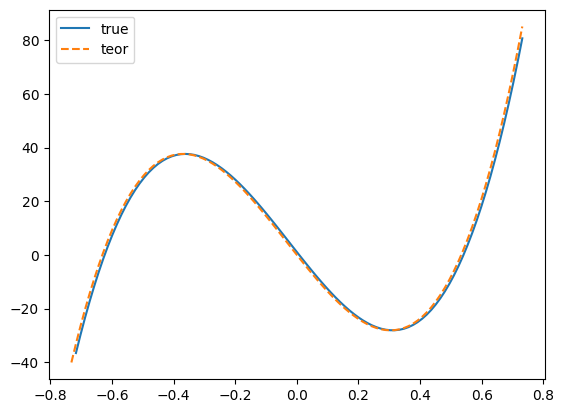

In [34]:
alphas=np.linspace(-semiangle_cutoff*1e-3,semiangle_cutoff*1e-3,100)
dalpha=alphas[1]-alphas[0]
kx=alphas*1/probe.wavelength
y=np.diff(probe.ctf.evaluate_chi(alphas,0))/dalpha/(2*np.pi/probe.wavelength)

plt.figure()
plt.plot(kx[1:],y,"-",label="true")
y_teor=np.real(shifts(kx,0,probe.wavelength))*1/probe.wavelength/(2*np.pi/probe.wavelength) # 1/probe.wavelength je ze zmeny promennych dk/dalpha
plt.plot(kx,y_teor,"--",label="teor")
plt.legend()


In [35]:
######################

In [36]:
der_kx_kx=sp.lambdify((k_x,k_y,lmbda),derivation_kx_kx.evalf(subs=aberrations_de),"numpy")
der_kx_ky=sp.lambdify((k_x,k_y,lmbda),derivation_kx_ky.evalf(subs=aberrations_de),"numpy")
der_ky_kx=sp.lambdify((k_x,k_y,lmbda),derivation_ky_kx.evalf(subs=aberrations_de),"numpy")
der_ky_ky=sp.lambdify((k_x,k_y,lmbda),derivation_ky_ky.evalf(subs=aberrations_de),"numpy")

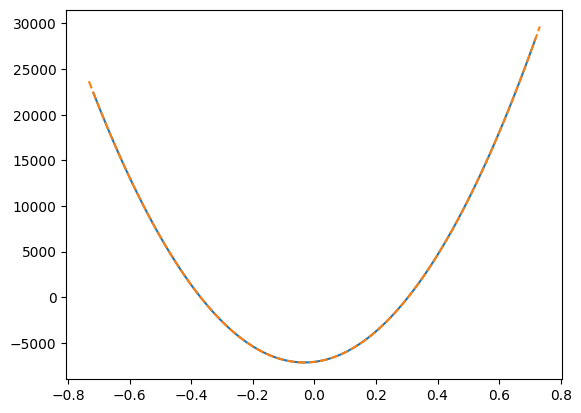

In [37]:
plt.figure()
y=np.diff(np.diff(probe.ctf.evaluate_chi(alphas,0)))/dalpha**2/(2*np.pi/probe.wavelength)
plt.plot(kx[1:-1],y,"-",label="true")
y_teor=np.real(der_kx_kx(kx,0,probe.wavelength))*1/probe.wavelength**2/(2*np.pi/probe.wavelength) #1/probe.wavelength je ze zmeny promennych dk/dalpha
plt.plot(kx,y_teor,"--",label="teor")

In [38]:
#######################

In [39]:
2048/(reciprocal_oversampling*2)

128.0

In [40]:
measurement.shape

(1024, 2048, 2048)

In [41]:
measurement_noisy.shape

(1024, 256, 256)

In [42]:
#?measurement_decimated = decimate_measurement(measurement,reciprocal_oversampling*2)

In [43]:
#measurement_decimated.shape

In [44]:
#?measurement_crop_bf=crop(measurement_decimated,extent=(semiangle_cutoff*2,semiangle_cutoff*2))

measurement_decimated = decimate_measurement(measurement_noisy,4)
measurement_crop_bf=crop(measurement_decimated,extent=(semiangle_cutoff*2,semiangle_cutoff*2))

In [45]:
measurement_crop_bf.shape

(1024, 32, 32)

(<Axes: xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x7f3ca83c88e0>)

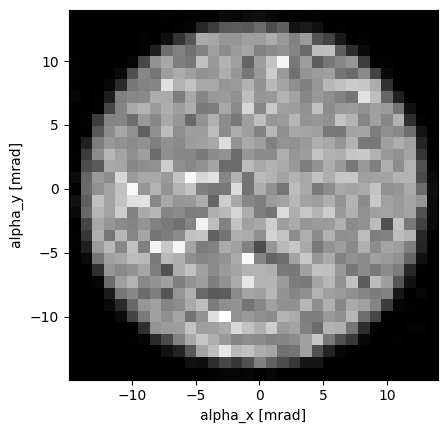

In [46]:
measurement_crop_bf[0].show()

In [47]:
from abtem.utils import fft_shift

In [48]:
img_1_=measurement_crop_bf.array.reshape(scan_gpts,scan_gpts,*measurement_crop_bf.shape[-2:])[:,:,3,3]
shiftx = 0.321
shifty = 0.123
img_2_=np.real(fft_shift(img_1_,np.array([shiftx,shifty])))
img_2_-=np.min(img_2_)
#img_2_=measurement_crop_bf.array.reshape(scan_gpts,scan_gpts,*measurement_crop_bf.shape[-2:])[:,:,32,16]

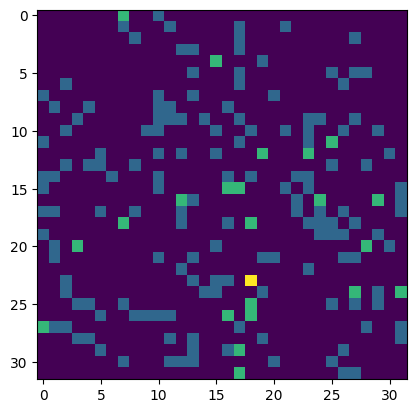

In [49]:
plt.figure()
plt.imshow(img_1_)

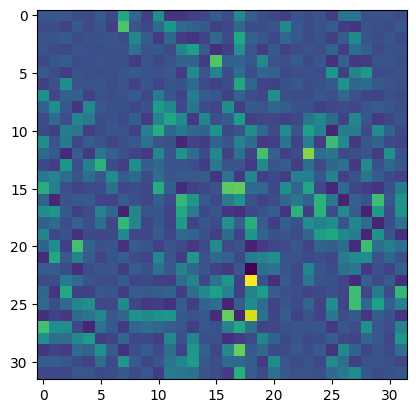

In [50]:
plt.figure()
plt.imshow(img_2_)

In [51]:
img_1=img_1_
img_2=img_2_

In [52]:
from py4DSTEM.process.utils.cross_correlate import align_images_fourier
from skimage.registration import phase_cross_correlation

In [53]:
%%time
G_ref=np.fft.fft2(img_1)
G=np.fft.fft2(img_2)
asdf=[]
asdf_2=[]
errors_2=[]
x=range(8,512)
for i in x:
    asdf.append(align_images_fourier(G_ref,G,upsample_factor=i,device="cpu")[1])
    shift, error, diffphase = phase_cross_correlation(img_1, img_2, upsample_factor=i)
    asdf_2.append(shift[1])
    errors_2.append(error)
plt.figure()
plt.plot(list(x),asdf,"x",label="py4DSTEM")
plt.plot(list(x),asdf_2,"x",label="scipy")
plt.axhline(y=-shifty)
plt.legend()

CPU times: user 15.5 s, sys: 25.6 s, total: 41.2 s
Wall time: 2.6 s


In [54]:
########################################

In [55]:
measurement_crop_bf_array=measurement_crop_bf.array.reshape(scan_gpts,scan_gpts,*measurement_crop_bf.shape[-2:])

In [56]:
measurement_crop_bf_array.shape

(32, 32, 32, 32)

In [57]:
from abtem.utils import spatial_frequencies
diffpat_gpts=measurement_crop_bf_array.shape[-2:]
diffpat_sampling=measurement_crop_bf.calibrations[-1].sampling # reciprocal sampling in mrad
kx, ky = get_spatial_frequencies(diffpat_gpts,diffpat_sampling,probe.wavelength)
#kx = xp.asarray(kx)                                                                                                                                                                    
#ky = xp.asarray(ky) 

In [58]:
assert True

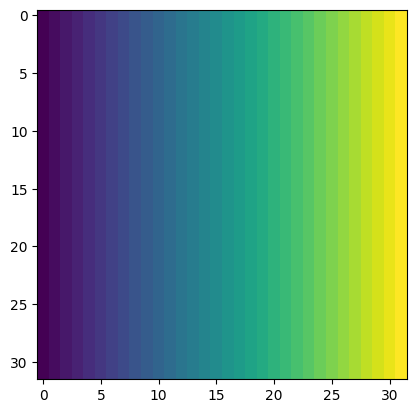

In [59]:
#%matplotlib inline
plt.figure()
plt.imshow(ky)

(<Axes: xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7f3ca8043cd0>)

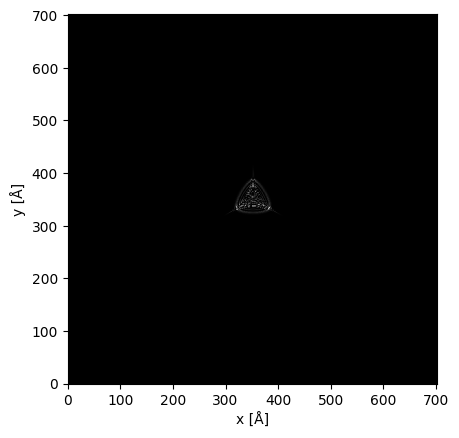

In [60]:
probe.show()

In [61]:
#chck
print(probe.sampling)
print(1/(512*measurement.calibrations[-1].sampling*1e-3*1/probe.wavelength))

(0.34302404806931014, 0.34302404806931014)
1.3720961922772406


In [62]:
plt.figure()
mean_image = np.mean(measurement_crop_bf_array,axis=(0,1))
mask = mean_image>mean_image.max()/1e4
plt.imshow(mask)

In [63]:
upsampling_factor = 50

In [64]:
measured_shifts_scipy = measure_shifts(measurement_crop_bf_array, mask, upsampling_factor=upsampling_factor, reg_tool='scipy')
measured_shifts = measure_shifts(measurement_crop_bf_array, mask,upsampling_factor=upsampling_factor, reg_tool='py4DSTEM')

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8


Could not determine RMS error between images with the normalized average intensities 0.0 and 9.969904336139264e-06. Either the reference or moving image may be empty.
Could not determine RMS error between images with the normalized average intensities 0.0 and 1.1077671484599182e-05. Either the reference or moving image may be empty.


0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
1 0
1 1
1 2
1 3
1 4


Could not determine RMS error between images with the normalized average intensities 0.0 and 8.862137187679346e-06. Either the reference or moving image may be empty.
Could not determine RMS error between images with the normalized average intensities 0.0 and 7.754370039219427e-06. Either the reference or moving image may be empty.
Could not determine RMS error between images with the normalized average intensities 0.0 and 6.09271931652955e-06. Either the reference or moving image may be empty.
Could not determine RMS error between images with the normalized average intensities 0.0 and 1.1077671484599182e-05. Either the reference or moving image may be empty.
Could not determine RMS error between images with the normalized average intensities 0.0 and 9.969904336139264e-06. Either the reference or moving image may be empty.


1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
0 0
0 1
0 2


Could not determine RMS error between images with the normalized average intensities 0.0 and 6.646602890759509e-06. Either the reference or moving image may be empty.
Could not determine RMS error between images with the normalized average intensities 0.0 and 4.984952168069632e-06. Either the reference or moving image may be empty.
Could not determine RMS error between images with the normalized average intensities 0.0 and 4.431068593839673e-06. Either the reference or moving image may be empty.
invalid value encountered in scalar divide
invalid value encountered in scalar divide


0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31


In [65]:
N = measurement_crop_bf_array.shape[-1]
for i in range(N):
    asdf = measurement_crop_bf_array[:,:,i,N//2]
    plt.figure()
    plt.imshow(asdf.T,origin="lower")
    plt.savefig("figs/figs_sch/{:04.0f}.pdf".format(i))
    plt.close()
    

In [66]:
#%matplotlib widget
plt.figure()
measured_shifts_apr=measured_shifts_scipy*scan_sampling/(diffpat_sampling*1e-3) # (Delta shift in angstrom) / (delta alpha in rad)
#measured_shifts_apr=measured_shifts*scan_sampling/(diffpat_sampling*1e-3) # (Delta shift in angstrom) / (delta alpha in rad)
measured_shifts_apr_x_x=measured_shifts_apr[:,:,0,0]
plt.imshow(measured_shifts_apr[:,:,0,0]) 

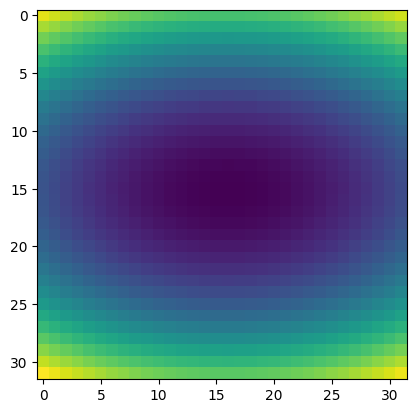

In [67]:
#%matplotlib widget
plt.figure()
teor_shifts_apr=np.real(der_kx_kx(kx,ky,probe.wavelength))*1/probe.wavelength**2/(2*np.pi/probe.wavelength)
#plt.plot(kx,y_teor,"--",label="teor")
plt.imshow(teor_shifts_apr)
plt.show()

In [68]:
measured_shifts_apr.shape

(32, 32, 2, 2)

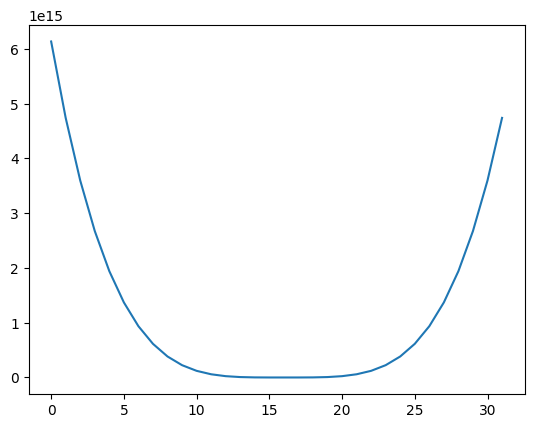

In [69]:
plt.figure()
plt.plot(probe.ctf.evaluate_chi(kx[:,N//2]*1/probe.wavelength,0))
plt.show()

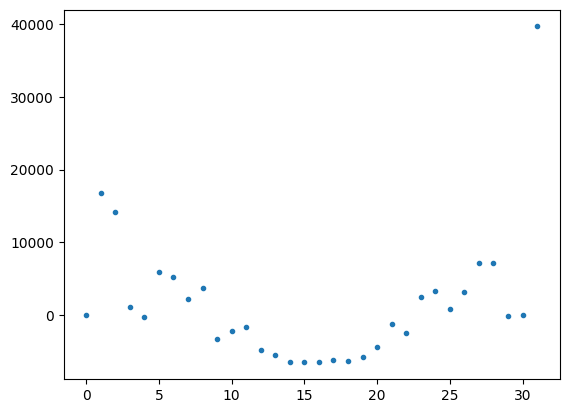

In [70]:
plt.figure()
plt.plot(measured_shifts_apr[:,N//2,0,0],".")

In [71]:
#%matplotlib widget

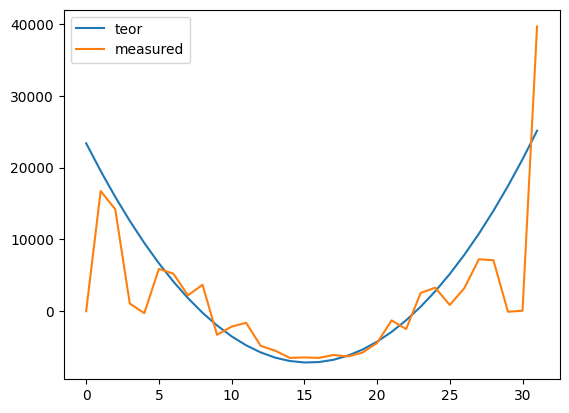

In [72]:
plt.figure()
plt.plot(teor_shifts_apr[:,N//2],label="teor")
plt.plot(measured_shifts_apr_x_x[:,N//2],label="measured")
plt.legend()

In [73]:
teor_shifts_apr[0,8]

26174.582

In [74]:
#################################xx FITOVANI

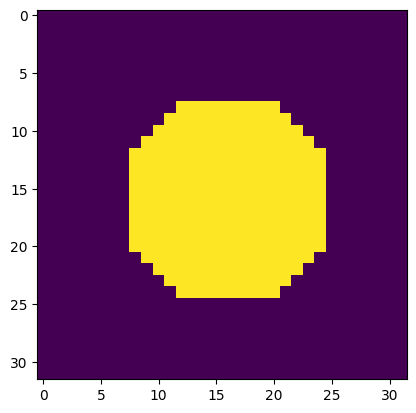

In [75]:
k=np.sqrt(kx**2+ky**2)
mask_fit=k<kx.max()*3/5 # 4/5
plt.figure()
plt.imshow(mask_fit)
kx_fit=kx[mask_fit]
ky_fit=ky[mask_fit]

In [76]:
aberrations_real_coefs

{(1, 0, 0): C_1,0,0,
 (1, 2, 0): C_1,2,0,
 (1, 2, 1): C_1,2,1,
 (2, 1, 0): C_2,1,0,
 (2, 1, 1): C_2,1,1,
 (2, 3, 0): C_2,3,0,
 (2, 3, 1): C_2,3,1,
 (3, 0, 0): C_3,0,0,
 (3, 2, 0): C_3,2,0,
 (3, 2, 1): C_3,2,1,
 (3, 4, 0): C_3,4,0,
 (3, 4, 1): C_3,4,1}

In [77]:
expr_120=derivation_kx_kx.expand().coeff(aberrations_real_coefs[1,2,0]) # as_coefficient() je pouze na podeleni expression mym koeficientem, coeff je potreba..
expr_120

2*pi*lambda

In [78]:
expr_120_fun=sp.lambdify((k_x,k_y,lmbda),expr_120.evalf(subs=aberrations_de),'numpy')
expr_120_fun

<function _lambdifygenerated(k_x, k_y, lambda_)>

In [79]:
nd_derivatives = np.array(                                                                                                                                                                 
                        [[derivation_kx_kx,derivation_kx_ky],                                                                                                                              
                        [derivation_ky_kx,derivation_ky_ky]]) # so that [0,0] is kx_kx [0,1] is kx_ky [1,0] is ky_kx and [1,1] is ky,ky                                                    
wave_deviation_nd_der_basis = get_nd_der_basis(aberrations_real_coefs,nd_derivatives,probe.wavelength,diffpat_gpts,diffpat_sampling,k_x,k_y,lmbda)   

In [80]:
wave_deviation_nd_der_basis.reshape(wave_deviation_nd_der_basis.shape[0],-1).shape

(12, 4096)

In [81]:
measured_shifts_apr.reshape(-1).shape

(4096,)

In [82]:
measured_shifts_apr[mask_fit,:,:].shape

(249, 2, 2)

In [83]:
wave_deviation_nd_der_basis[:,mask_fit,:,:].shape

(12, 249, 2, 2)

In [84]:
mask_fit.shape

(32, 32)

In [85]:
aberrations

{'C10': -7077, 'C30': 50000000.0, 'C12': 0.02, 'C23': 100000}

In [86]:
aberrations_coefs, res = np.linalg.lstsq(
                wave_deviation_nd_der_basis[:,mask_fit,:,:].reshape(wave_deviation_nd_der_basis.shape[0],-1).T, measured_shifts_apr.transpose((0,1,2,3))[mask_fit,:,:].reshape(-1), rcond=None
            )[:2]

In [87]:
aberrations_coefs

array([-6.12040353e+03, -1.00093036e+02,  5.38017198e+01, -7.74744353e+03,
        4.64410573e+03, -6.90438277e+03,  1.07628439e+05,  4.53707889e+07,
        3.36490558e+06,  2.95613363e+06,  3.36554635e+06,  6.72264834e+05])

In [88]:
#z baze odhadnout jaka je chyba prislusi dane aberaci: 
#podle toho jak se meni posun druha derivace vlnoplochy dx/dalpha=Defocus*1 
#abych dostal ekvivalentni posun prenasobym dalpha: dx=Defocus*1 * diffpat_sampling 
# pro pripad ostatnich aberaci bude misto *1 vystupovat jiny vyraz (baze) 
# vezmu max baze (basis_max) (nebo nejaky median) a to vezmu na odhad presnosti prislusne aberace: 
# Delta_aberration = scan_sampling/basis_max/diffpat_sampling 
# scan_sampling se da vzit mensi podle toho jaka ja upsampling presnost.

#Pozor vysledek neni chyba ale jakysi odhad nejistoty

In [89]:
diffpat_sampling*1e-3

0.0009333333333333333

In [90]:
basis_max=np.quantile(np.abs(wave_deviation_nd_der_basis)[:,mask_fit,:,:].reshape(wave_deviation_nd_der_basis.shape[0],-1),axis=(1),q=0.75)
expected_sensitivity = scan_sampling/basis_max/(diffpat_sampling*1e-3)*1/(upsampling_factor)
expected_sensitivity #Pozor vysledek neni chyba ale jakysi odhad nejistoty

array([6.69642857e+01, 6.69642857e+01, 6.69642857e+01, 1.53744539e+04,
       1.53744539e+04, 5.97895380e+03, 5.97895380e+03, 1.06767027e+06,
       1.60150563e+06, 1.02496344e+06, 6.40602176e+05, 6.40602176e+05])

In [91]:
np.log10(22e3)

4.342422680822207

In [92]:
np.round(22e3,int(np.log10(22e3)))

22000.0

In [93]:
aberrations_real_coefs.keys()

dict_keys([(1, 0, 0), (1, 2, 0), (1, 2, 1), (2, 1, 0), (2, 1, 1), (2, 3, 0), (2, 3, 1), (3, 0, 0), (3, 2, 0), (3, 2, 1), (3, 4, 0), (3, 4, 1)])

In [94]:
from uncertainties import unumpy as unp
res=unp.uarray(aberrations_coefs,expected_sensitivity)
for i,_ in enumerate(res):
    print('{}: {:.1u}'.format(list(aberrations_real_coefs.keys())[i],res[i]))

(1, 0, 0): (-6.12+/-0.07)e+03
(1, 2, 0): (-1.0+/-0.7)e+02
(1, 2, 1): (5+/-7)e+01
(2, 1, 0): (-1+/-2)e+04
(2, 1, 1): (0+/-2)e+04
(2, 3, 0): (-7+/-6)e+03
(2, 3, 1): (1.08+/-0.06)e+05
(3, 0, 0): (4.5+/-0.1)e+07
(3, 2, 0): (3+/-2)e+06
(3, 2, 1): (3+/-1)e+06
(3, 4, 0): (3.4+/-0.6)e+06
(3, 4, 1): (7+/-6)e+05


In [95]:
fitted_shifts_apr=np.sum( wave_deviation_nd_der_basis*aberrations_coefs[:,None,None,None,None],axis=0)

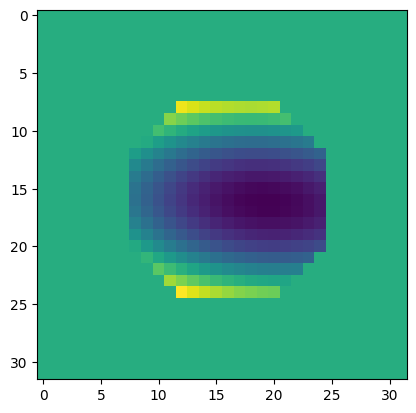

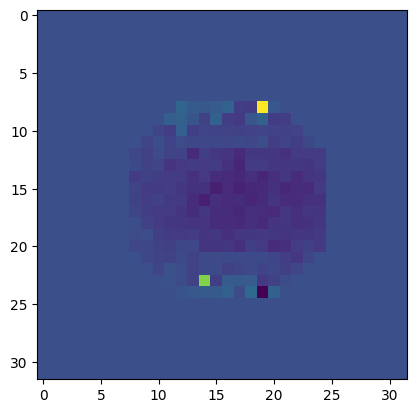

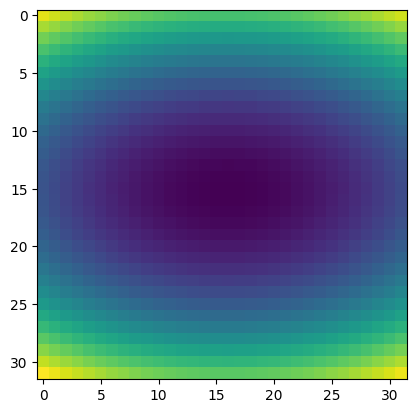

In [96]:
plt.figure()
plt.imshow(fitted_shifts_apr[:,:,0,0]*mask_fit)
plt.figure()
plt.imshow(measured_shifts_apr[:,:,0,0]*mask_fit)
y_=np.real(der_kx_kx(kx,ky,probe.wavelength))*1/probe.wavelength**2/(2*np.pi/probe.wavelength)
plt.figure()
plt.imshow(y_)

In [97]:
np.array(list(aberrations_real_coefs.keys()))

array([[1, 0, 0],
       [1, 2, 0],
       [1, 2, 1],
       [2, 1, 0],
       [2, 1, 1],
       [2, 3, 0],
       [2, 3, 1],
       [3, 0, 0],
       [3, 2, 0],
       [3, 2, 1],
       [3, 4, 0],
       [3, 4, 1]])

In [98]:
dict(zip(list(aberrations_real_coefs.keys()),aberrations_coefs))

{(1, 0, 0): -6120.403529422101,
 (1, 2, 0): -100.09303601831198,
 (1, 2, 1): 53.8017198224552,
 (2, 1, 0): -7747.44353329311,
 (2, 1, 1): 4644.105729736776,
 (2, 3, 0): -6904.382767409914,
 (2, 3, 1): 107628.43882460719,
 (3, 0, 0): 45370788.92781305,
 (3, 2, 0): 3364905.575834237,
 (3, 2, 1): 2956133.62958006,
 (3, 4, 0): 3365546.3526428547,
 (3, 4, 1): 672264.8337439274}

In [99]:
aberrations_fitted=aberration_dict_polar(dict(zip(list(aberrations_real_coefs.keys()),aberrations_coefs)),np.array(list(aberrations_real_coefs.keys())))
aberrations_fitted

{'C10': -6120.403529422101,
 'C12': 113.63644184511,
 'phi12': 2.894988186338267,
 'C21': 9032.751481721345,
 'phi21': 4.172383418646314,
 'C23': 107849.67012105841,
 'phi23': 2.115749232352901,
 'C30': 45370788.92781305,
 'C32': 4478985.997992683,
 'phi32': 1.9312061338249449,
 'C34': 3432031.797416273,
 'phi34': 1.620084899833619}

(<Axes: xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7f3c906ac730>)

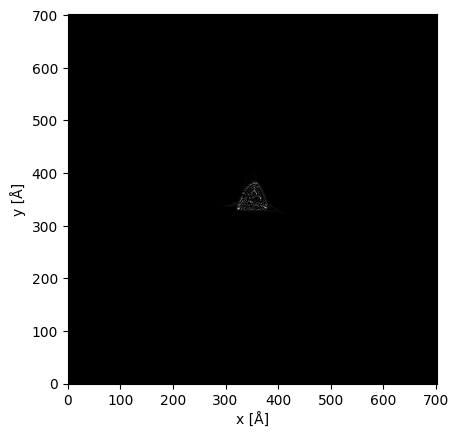

In [100]:
Probe(energy=energy,semiangle_cutoff=semiangle_cutoff,**aberrations_fitted,sampling=sampling,extent=extent).show()

(<Axes: xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7f3c906ffb50>)

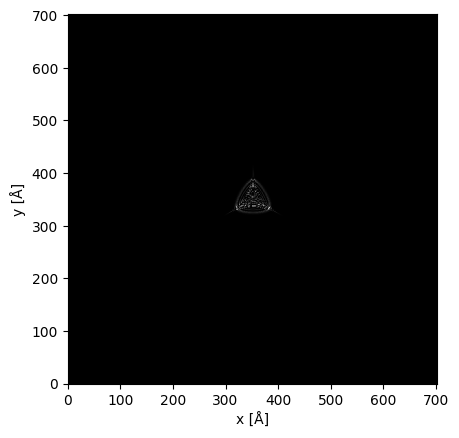

In [101]:
probe.show()


In [102]:
aberrations

{'C10': -7077, 'C30': 50000000.0, 'C12': 0.02, 'C23': 100000}

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
(1, 0, 0): -6.1e+03+/-0.2e+03	0.03	-6.1e+03+/-0.2e+03	0.02	-6.1e+03+/-0.1e+03		0.02
(1, 2, 0): -1e+02+/-2e+02	1.89	-1e+02+/-2e+02	1.79	-1e+02+/-1e+02		1.34
(1, 2, 1): 1e+02+/-2e+02	3.43	1e+02+/-1e+02	2.68	1e+02+/-1e+02		2.49
(2, 1, 0): -1e+04+/-2e+04	2.51	-1e+04+/-2e+04	2.51	-1e+04+/-3e+04		3.47
(2, 1, 1): 0e+04+/-2e+04	4.19	0e+04+/-2e+04	4.19	0e+04+/-3e+04		5.79
(2, 3, 0): -1e+04+/-1e+04	1.63	-1e+04+/-1e+04	1.63	-7e+03+/-9e+03		1.30
(2, 3, 1): 1.1e+05+/-0.1e+05	0.10	1.1e+05+/-0.1e+05	0.10	1.08e+05+/-0.09e+05		0.08
(3, 0, 0): 4.5e+07+/-0.2e+07	0.05	4.5e+07+/-0.2e+07	0.05	4.5e+07+/-0.2e+07		0.04
(3, 2, 0): 3e+06+/-3e+06	0.78	3e+06+/-3e+06	0.78	3.364905575834237e+06+/-00inf		inf
(3, 2, 1): 3e+

divide by zero encountered in divide


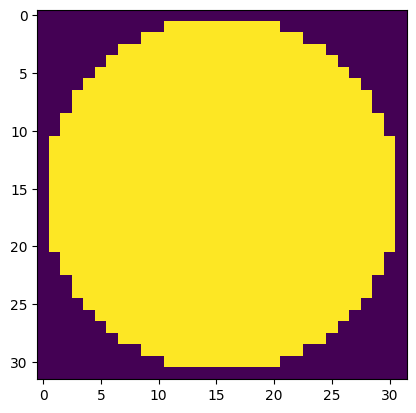

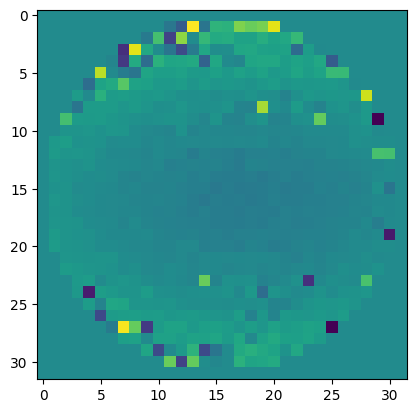

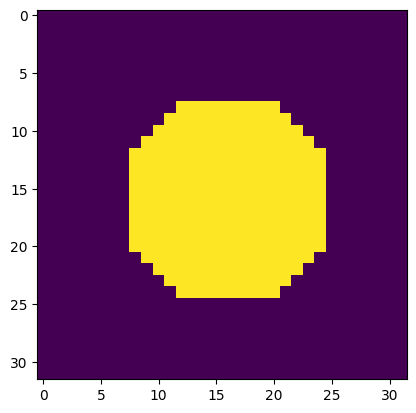

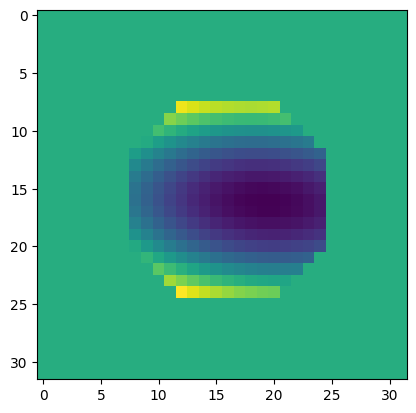

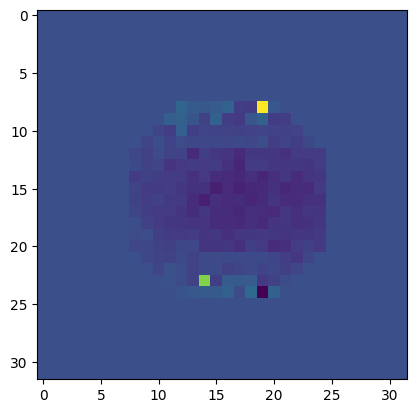

In [103]:
diffpat_sampling = measurement_crop_bf.calibrations[-1].sampling
asdf=example(measurement_crop_bf_array,diffpat_sampling,scan_sampling,probe.wavelength)

In [104]:
#exec(open("./aberrations_fit_utils.py").read())